In [1]:
import numpy as np
import pandas as pd
from math import isnan
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_predict
import scipy as sp
import scipy.stats
import random

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
hiae = pd.read_csv("data/hiae.csv")
hmvsc = pd.read_csv("data/hmvsc.csv")

## Data prep

In [3]:
# Valid variable thresholds
thresholds = {
    'highest_respiratory_rate1h': [1, 80],
    'highest_temperature1h': [25, 46],
    'highest_heart_rate1h': [20, 220],
    'lowest_mean_arterial_pressure1h': [1, 200],
    'lowest_diastolic_blood_pressure1h': [1, 200],
    'lowest_systolic_blood_pressure1h': [1, 300],
    'bmi': [10, 70]
}

In [4]:
normal = {
    'highest_respiratory_rate1h': 16,
    'highest_temperature1h': 37,
    'highest_heart_rate1h': 80,
    'lowest_mean_arterial_pressure1h': 90,
    'lowest_diastolic_blood_pressure1h': 80,
    'lowest_systolic_blood_pressure1h': 120,
    'lengthhospitalstaypriorunitadmission': 0
}

In [5]:
# Function to remove invalid thresholds
def remove_invalid(df, thresholds):
    for c in thresholds:
        df.loc[(df[c] < thresholds[c][0]) | (df[c] > thresholds[c][1]), c] = np.nan

In [6]:
# Remove invalid thresholds
remove_invalid(hiae, thresholds)
remove_invalid(hmvsc, thresholds)

In [7]:
# Group glasgow
def group_gcs(gcs):
    if isnan(gcs):
        return np.nan
    
    gcs = int(gcs)
    if gcs < 15:
        return 1
    elif gcs == 15:
        return 2

In [8]:
def group_adm_src(df):
     df['admissionsourcename'].replace({
         'Enfermaria / quarto': 'floor',
         'Centro Cirúrgico': 'operating room',
         'Sala de hemodinâmica': 'operating room',
         'Emergência': 'emergency room',
         'Home-care': 'emergency room', 
         'Transferência de outro hospital/instituição': 'other sources',
         'Outra UTI/UCI do seu hospital': 'other icu',
         'Unidade Semi-intensiva': 'other sources',
         'Outra - Não especificada': 'other sources'
     }, inplace=True)

In [9]:
# Group gcs
hiae['glasgow'] = hiae['lowest_glasgow_coma_scale1h'].apply(group_gcs)
hmvsc['glasgow'] = hmvsc['lowest_glasgow_coma_scale1h'].apply(group_gcs)

# Group admission source
group_adm_src(hiae)
group_adm_src(hmvsc)

In [10]:
class CustomImputer:
    """
    Impute mode for each categorical column and pre-defined normal values otherwise.
    """
    def __init__(self, normal, c_cols):
        self.normal = normal
        self.c_cols = c_cols

    def fit(self, X, y=None):
        self.modes = [(c, X[c].dropna().mode()[0]) for c in self.c_cols]
        return self

    def transform(self, X):
        output = X.copy()
        for c, v in self.normal.items():
            output[c].fillna(v, inplace=True)
        for c, v in self.modes:
            output[c].fillna(v, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [11]:
class CustomLabelEncoder:
    def __init__(self, values):
        self.values = values

    def fit(self, X, y=None):
        self.encoders = [(c, LabelEncoder().fit(v)) for c, v in self.values]
        return self

    def transform(self, X):
        output = X.copy()
        for c, e in self.encoders:
            output.loc[output[c].notna(), c] = e.transform(output.loc[output[c].notna(), c])
            output[c].fillna(-1, inplace=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [12]:
class OneHotEncoder:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        output = X.copy()
        output = pd.get_dummies(output, columns=self.columns, drop_first=True)
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [13]:
class CustomScaler:
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        self.scalers = [(c, StandardScaler().fit(X[c].astype(float).values.reshape(-1,1))) for c in self.columns]
        return self

    def transform(self, X):
        output = X.copy()
        for c, s in self.scalers:
            output[c] = s.transform(output[c].astype(float).values.reshape(-1,1))
        return output

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [14]:
# Lists of variable types
target = "hospitalexpireflag"

#pre icu
demographic = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name",
               "age", "lengthhospitalstaypriorunitadmission", "bmi_group"]

#lab results
physiological = ["lowest_systolic_blood_pressure1h", "lowest_diastolic_blood_pressure1h",
                 "lowest_mean_arterial_pressure1h", "highest_heart_rate1h", "highest_respiratory_rate1h",
                 "highest_temperature1h"]

glasgow = ["glasgow"]
                 
c_cols_og = ["genders", "admissionsourcename", "admissiontypename", "chronic_health_status_name", 
          "glasgow", "bmi_group"]

n_cols_og = ["age", "lowest_systolic_blood_pressure1h", 
          "lowest_diastolic_blood_pressure1h","lowest_mean_arterial_pressure1h", "highest_heart_rate1h", 
          "highest_respiratory_rate1h", "highest_temperature1h", "lengthhospitalstaypriorunitadmission"]

### Helper Functions To Run The Models

In [15]:
def predict_probs(pipeline, X_hiae, y_hiae, X_hmvsc, y_hmvsc):
    
    # HIAE, Run model
    y_pred_hiae = cross_val_predict(pipeline, X_hiae, y_hiae, cv=5, method='predict_proba')

    # Numpy array of probs
    y_true_hiae = np.array(y_hiae)
    y_pred_hiae = np.array(y_pred_hiae)

    # HMVSC, Run model
    model = pipeline.fit(X_hiae, y_hiae)

    # Predict probs
    y_true_hmvsc = np.array(y_hmvsc)
    y_pred_hmvsc = np.array(pipeline.predict_proba(X_hmvsc))
    
    # Get mortality rates
    mort_hiae = sum(y_true_hiae)/y_true_hiae.size
    X_rec_hiae = pd.DataFrame(y_pred_hiae[:,1])
    X_rec_hiae["mort"] = mort_hiae
    
    mort_hmvsc = sum(y_true_hmvsc)/y_true_hmvsc.size
    X_rec_hmvsc = pd.DataFrame(y_pred_hmvsc[:,1])
    X_rec_hmvsc["mort"] = mort_hmvsc
    
    run_model(pipeline, X_rec_hiae, y_hiae, X_rec_hmvsc, y_hmvsc)

In [ ]:
def train_model(pipe, X, y, seed=42):
    # Split
    X_train_hiae, X_test_hiae, y_train_hiae, y_test_hiae = train_test_split(X_rec_hiae, y_rec_hiae,
                                                                            test_size=y_rec_hiae.size-600
                                                                            , stratify=y_rec_hiae, random_state=seed)
    

In [37]:
def run_model(pipeline, X_rec_hiae, y_hiae, X_rec_hmvsc, y_hmvsc):
    
    y_rec_hiae = y_hiae.copy()
    y_rec_hmvsc = y_hmvsc.copy()
    
    # Split
    X_train_hiae, X_test_hiae, y_train_hiae, y_test_hiae = train_test_split(X_rec_hiae, y_rec_hiae, 
                                                        test_size=y_rec_hiae.size-600
                                                                            , stratify=y_rec_hiae, random_state=42)
    
    X_train_hmvsc, X_test_hmvsc, y_train_hmvsc, y_test_hmvsc = train_test_split(X_rec_hmvsc, y_rec_hmvsc, 
                                                        test_size=y_rec_hmvsc.size-600
                                                                            , stratify=y_rec_hmvsc, random_state=42)
    X_train = X_train_hmvsc.append(X_train_hiae)
    y_train = y_train_hmvsc.append(y_train_hiae)
    
    # Run models
    rec = LogisticRegression(class_weight={0:1.9,1:1.7})
    rec.fit(X_train, y_train)

    # Predict probs
    y_true_hmvsc = y_test_hmvsc
    y_pred_hmvsc = rec.predict_proba(X_test_hmvsc)[:,1]
    
    y_true_hiae = y_test_hiae
    y_pred_hiae = rec.predict_proba(X_test_hiae)[:,1]
    
    # Calculate SMR values for both
    print(sum(y_true_hiae)/sum(y_pred_hiae), 'SMR HIAE')
    print(sum(y_true_hmvsc)/sum(y_pred_hmvsc), 'SMR HMVSC')
    
    # Plot the data
    plot_deciles(y_pred_hiae, y_true_hiae, y_pred_hmvsc, y_true_hmvsc)

In [120]:
def plot_calib_curve(y_true, y_pred, ax = None, n_bins = 10, with_histogram=False, width=0.1, **kwargs):
    if type(y_true) is list:
        y_true = np.asarray(y_true)
    if type(y_pred) is list:
        y_pred = np.asarray(y_pred)
        
    # Metrics Logit
    if ax is None:
        ax=plt.gca()
        
    # calculate AUROC
    auc = roc_auc_score(y_true, y_pred)
    
    # add AUROC to legend
    if 'label' not in kwargs:
        kwargs['label'] = ''
    kwargs['label'] += ', auc={:0.3f}'.format(auc)
    
    xi = np.linspace(0, 1, n_bins+1)
    
    expected  = np.ones(n_bins)*np.nan
    observed = np.ones(n_bins)*np.nan
    N = np.zeros(n_bins)
    for i in range(len(xi)-1):
        idx = (y_pred > xi[i]) & (y_pred <= xi[i+1])
        if np.any(idx):
            expected[i] = np.sum(y_pred[idx])
            observed[i] = np.sum(y_true[idx])
            N[i] = np.sum(idx)
        
    
    # calibration curve
    p = ax.plot(expected/N, observed/N, **kwargs)
    #fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_pred, n_bins=n_bins)
    #p = ax.plot(mean_predicted_value, fraction_of_positives, **kwargs)
    
    if with_histogram:
        # add transparent histogram
        c = p[0].get_color()
        ax.bar(expected/N, N/np.sum(N), width=width, alpha=0.5, facecolor=c)
    #Calculate CI for both
    #print(mean_confidence_interval(y_pred_hiae+y_true_hiae), 'CI HIAE')

In [39]:
def plot_deciles(y_pred_hiae, y_true_hiae, y_pred_hmvsc, y_true_hmvsc):
    # Metrics Logit

    # Perfectly calibrated curve
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    # Define number of bins
    n_bins = 10
    pct = np.linspace(0, 100, n_bins+1)

    # HIAE metrics
    print(roc_auc_score(y_true_hiae, y_pred_hiae), "AUC HIAE")
    
    ytrue = np.zeros(n_bins)
    yhat  = np.zeros(n_bins)
    
    xi = np.percentile(y_pred_hiae, pct)
    
    for i in range(len(xi)-1):
        idx = (y_pred_hiae > xi[i]) & (y_pred_hiae <= xi[i+1])
        yhat[i] = np.mean(y_pred_hiae[idx])
        ytrue[i] = np.mean(y_true_hiae[idx])
    ax1.plot(yhat, ytrue, "s-",
                 label="HIAE")
    
    # HMVSC metrics
    auc_hmvsc = roc_auc_score(y_true_hmvsc, y_pred_hmvsc)
    print(auc_hmvsc, "AUC HMVSC")
    
    
    ytrue = np.zeros(n_bins)
    yhat  = np.zeros(n_bins)
    xi = np.percentile(y_pred_hmvsc, pct)
    
    for i in range(len(xi)-1):
        idx = (y_pred_hmvsc > xi[i]) & (y_pred_hmvsc <= xi[i+1])
        yhat[i] = np.mean(y_pred_hmvsc[idx])
        ytrue[i] = np.mean(y_true_hmvsc[idx])
    ax1.plot(yhat, ytrue, "s-",
                 label="HMVSC")
    
    #Calculate CI for both
    print(mean_confidence_interval(y_pred_hiae+y_true_hiae), 'CI HIAE')
    print(mean_confidence_interval(y_pred_hmvsc+y_true_hmvsc), 'CI HMVSC')

    # Plot calibration
    plt.legend()
    plt.show()

In [42]:
def columns2block(block):
    if block == 1:
        columns = physiological
    elif block == 2:
        columns = demographic
    elif block == 3:
        columns = physiological + demographic
    elif block == 4:
        columns = physiological + demographic + glasgow
    return columns

In [19]:
def mean_confidence_interval(data, confidence=0.95):
    '''Confidence Interval calculator'''
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m-h, m+h

In [88]:
def prep_data_and_pipeline(hiae, hmvsc, columns, target, model='lr'):
    # Seperate x and y values
    X_hiae = hiae[columns].copy()
    X_hmvsc = hmvsc[columns].copy()
    
    y_hiae = hiae[target].copy()
    y_hmvsc = hmvsc[target].copy()    
    
    # Create null flag column
    for c in X_hiae.columns:
        X_hiae[c+"_null"] = X_hiae[c].isna().astype(int)
        X_hmvsc[c+"_null"] = X_hmvsc[c].isna().astype(int)

    # Get unique values for categorical features, after filtering the columns according to each block
    c_cols = [c for c in c_cols_og if c in X_hiae.columns]
    n_cols = [n for n in n_cols_og if n in X_hiae.columns]

    values = [(c, X_hiae.append(X_hmvsc).dropna()[c].unique()) for c in c_cols]

    #Normal values filtered for each block
    filtered_normal = {}
    for key in normal.keys():
        if key in n_cols: filtered_normal[key] = normal[key]
    
    
    if model in ('lr','logr'):
        # Model
        logr = LogisticRegression(solver='liblinear', penalty='l1')
        # Create pipeline
        pipe = Pipeline([
            ("imputer", CustomImputer(filtered_normal, c_cols)),
            ("encoder", CustomLabelEncoder(values)),
            ("ohe", OneHotEncoder(c_cols)),
            ("scaler", CustomScaler(n_cols)),
            ("model", logr)])
    elif model in ('xgb','xbst'):
        # Model
        xbst = XGBClassifier(n_estimators=100, max_depth=2)

        # Create pipeline
        pipe = Pipeline([
            ("lenc", CustomLabelEncoder(values)),
            ("model", xbst)
        ])
    elif model in ('xgbi','xgb_impute'):
        # Create pipeline
        pipe = Pipeline([
            ("imputer", CustomImputer(filtered_normal, c_cols)),
            ("lenc", CustomLabelEncoder(values)),
            ("model", xgbi)
        ])
    else:
        raise ValueError('Unrecognized model.')
        
    return X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe

## Logit trained in HIAE data

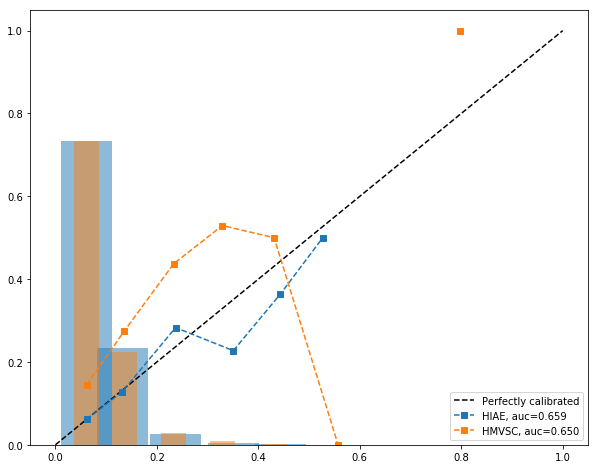

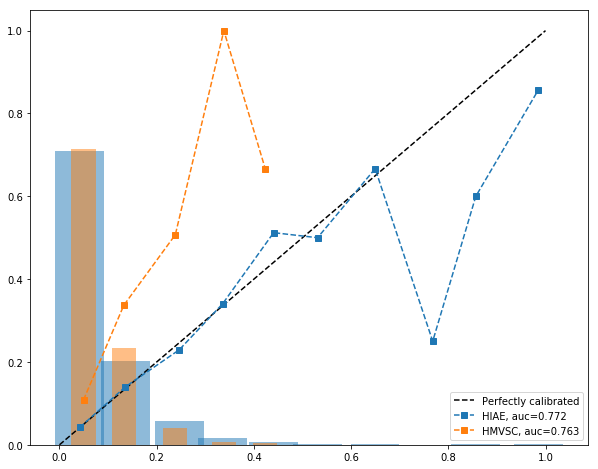

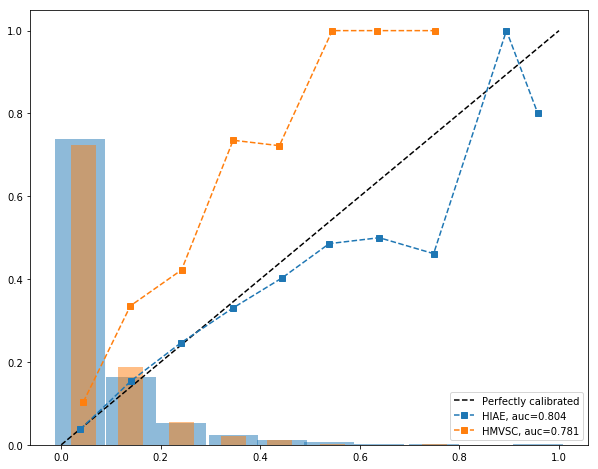

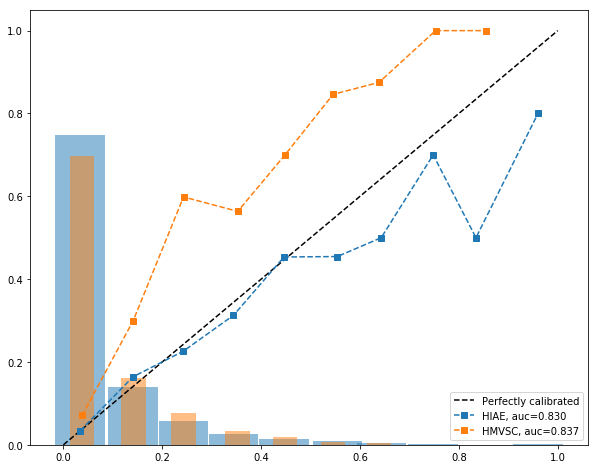

In [128]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='lr')
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")

    # Calculate SMR values for both
    #print(sum(y_hiae)/sum(y_pred_hiae), 'SMR HIAE')
    #print(sum(y_hmvsc)/sum(y_pred_hmvsc), 'SMR HMVSC')
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE data

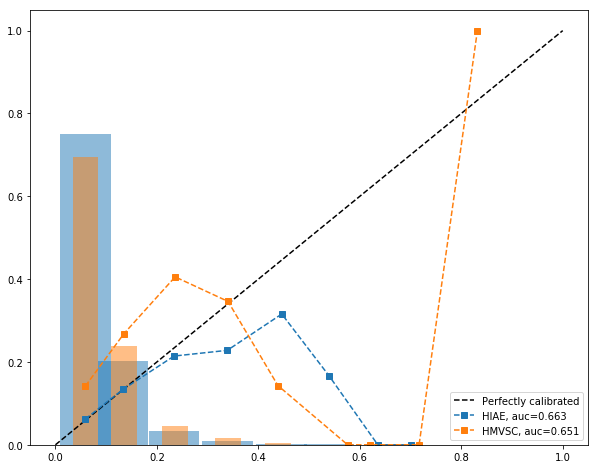

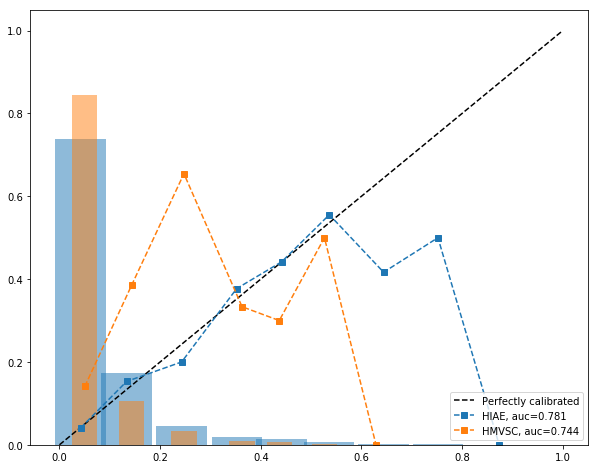

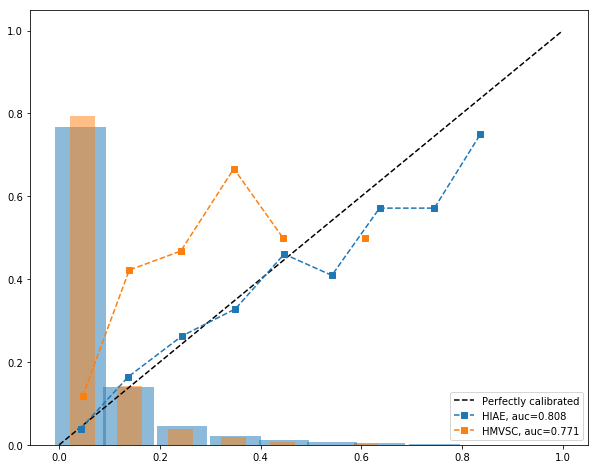

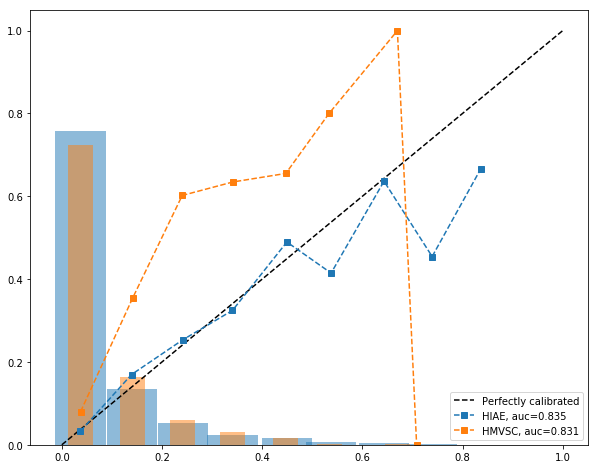

In [129]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgb')
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")

    # Calculate SMR values for both
    #print(sum(y_hiae)/sum(y_pred_hiae), 'SMR HIAE')
    #print(sum(y_hmvsc)/sum(y_pred_hmvsc), 'SMR HMVSC')
    
    plt.legend(loc='lower right')
    plt.show()

## XGBoost trained in HIAE imputed data

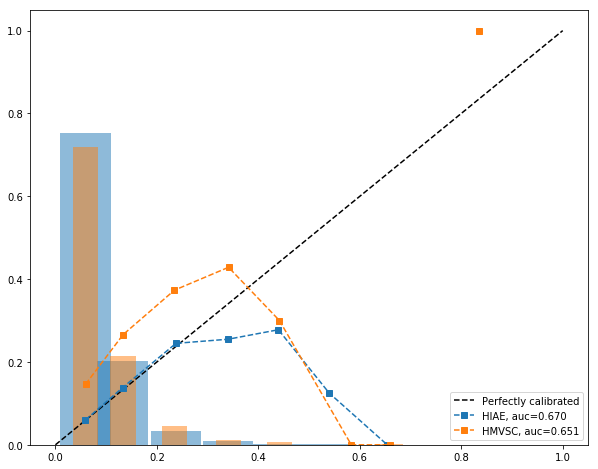

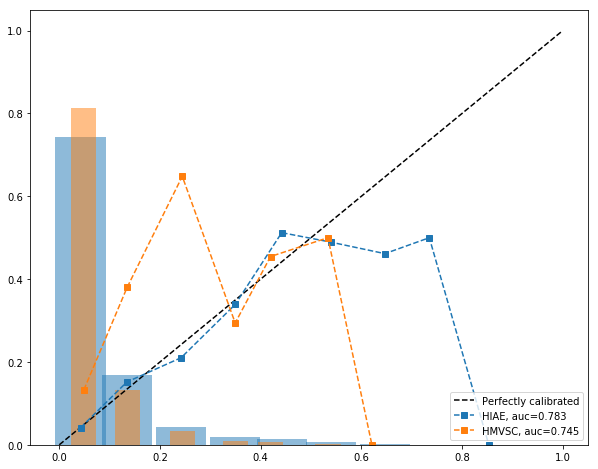

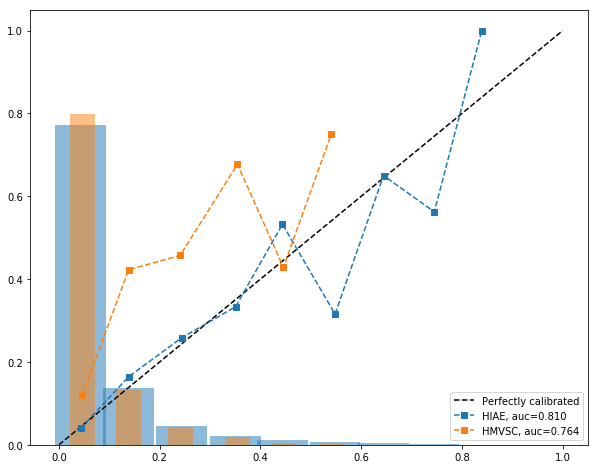

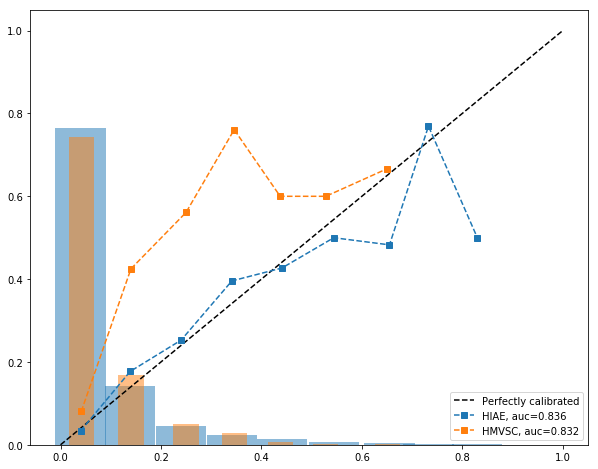

In [130]:
'''Run the model on each of the four blocks'''
for block in range(1,5):
    # prepare data
    X_hiae, y_hiae, X_hmvsc, y_hmvsc, pipe = prep_data_and_pipeline(
        hiae.copy(), hmvsc.copy(), columns2block(block), target, model='xgbi')
    
    
    #== train model on hiae
    model = pipe.fit(X_hiae, y_hiae)
    
    #== make predictions
    y_pred_hmvsc = model.predict_proba(X_hmvsc)[:,1]
    
    # also get cross-validation performance on hiae
    y_pred_hiae = cross_val_predict(model, X_hiae, y_hiae, cv=5, method='predict_proba')[:,1]
    
    
    # plot performance
    plt.figure(figsize=[10,8])
    ax = plt.gca()
    ax.plot([0,1],[0,1], linestyle='--', color='k', label="Perfectly calibrated")
    plot_calib_curve(y_true_hiae, y_pred_hiae, ax=ax,
                     with_histogram=True, width=0.1,
                     marker="s", linestyle='--', label="HIAE")
    plot_calib_curve(y_true_hmvsc, y_pred_hmvsc, ax=ax,
                     with_histogram=True, width=0.05,
                     marker="s", linestyle='--', label="HMVSC")

    # Calculate SMR values for both
    #print(sum(y_hiae)/sum(y_pred_hiae), 'SMR HIAE')
    #print(sum(y_hmvsc)/sum(y_pred_hmvsc), 'SMR HMVSC')
    
    plt.legend(loc='lower right')
    plt.show()